In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
import stan_utility

In [3]:
import stan

# Bayesian Inference

### fake data

In [101]:
from faker import Faker # library for generating random num

In [102]:
faker = Faker()
Faker.seed(1000)

In [103]:
# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(3000)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(3000)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'Insulin': [faker.random_int() for _ in range(3000)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(3000)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(3000)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(3000)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(3000)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13,59,24,99,6861,40.375093,1.122980,90,1
1,3,198,62,54,7416,60.019936,1.164683,84,1
2,12,89,42,80,7606,29.901838,0.776493,50,0
3,11,169,66,73,9796,18.782294,2.959806,82,1
4,2,24,60,76,247,13.799934,1.003071,90,0


In [104]:
df_simu.describe()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8.546000,101.152667,50.608333,49.796667,4960.285333,33.350612,1.487909,50.666667,0.497333
std,5.159078,58.629718,29.006288,29.239134,2856.292654,19.085782,0.867345,29.201538,0.500076
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.013702,0.000393,1.000000,0.000000
25%,4.000000,51.000000,26.000000,25.000000,2485.250000,16.784712,0.733832,25.000000,0.000000
50%,8.000000,102.000000,51.000000,50.000000,4942.500000,33.096036,1.477582,50.000000,0.000000
75%,13.000000,153.000000,75.000000,75.000000,7436.250000,49.275035,2.233451,77.000000,1.000000
max,17.000000,200.000000,100.000000,100.000000,9994.000000,66.993839,2.999799,100.000000,1.000000


/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_1403/2277086940.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')


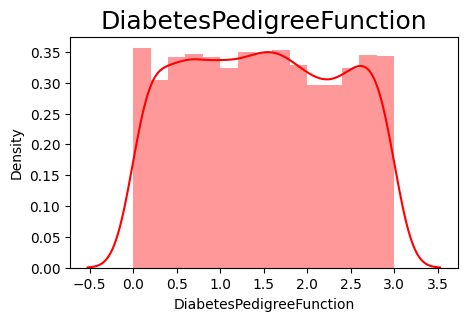

In [105]:
plt.figure(figsize=(5,3))
sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')
plt.title('DiabetesPedigreeFunction',size=18)
# plt.xlabel('Charges',size=14)
# plt.ylabel('Density',size=14)
plt.show()

<Axes: xlabel='Glucose', ylabel='DiabetesPedigreeFunction'>

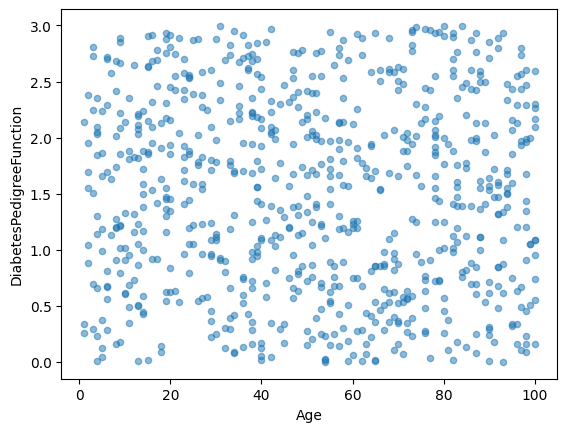

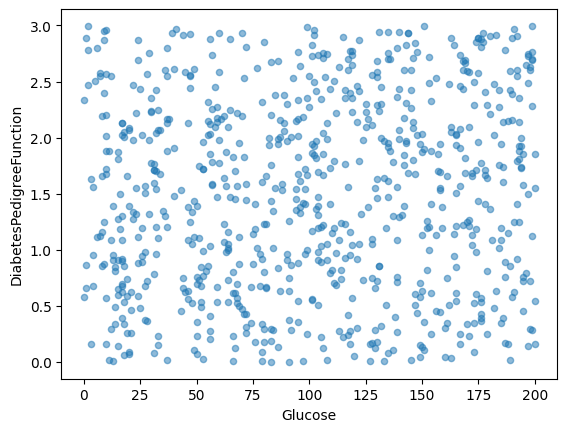

In [14]:
# print(df.loc[:, 'Outcome'].values)
df_simu.sort_values(by='Age').reset_index(drop=True).plot.scatter(x='Age', y="DiabetesPedigreeFunction", alpha=0.5)
df_simu.sort_values(by='Glucose').reset_index(drop=True).plot.scatter(x='Glucose', y="DiabetesPedigreeFunction", alpha=0.5)

## 1. Bayseian modeling

In [4]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [5]:
import pandas as pd
import csv

In [6]:
import scipy.stats as stats

In [7]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [189]:
# df["age_over35"] = (df['Age'] > 35).astype(int)

In [173]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_1403/629279425.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.BloodPressure,color='r')


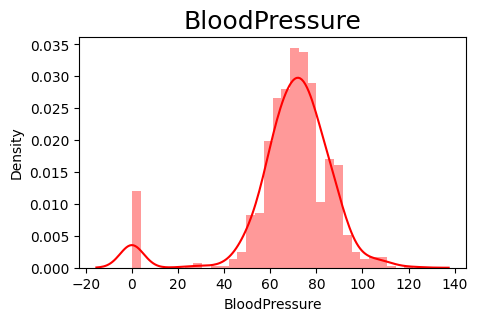

In [131]:
plt.figure(figsize=(5,3))
sns.distplot(df.BloodPressure,color='r')
plt.title('BloodPressure',size=18)
# plt.xlabel('Charges',size=14)
# plt.ylabel('Density',size=14)
plt.show()

<Axes: xlabel='Pregnancies', ylabel='BloodPressure'>

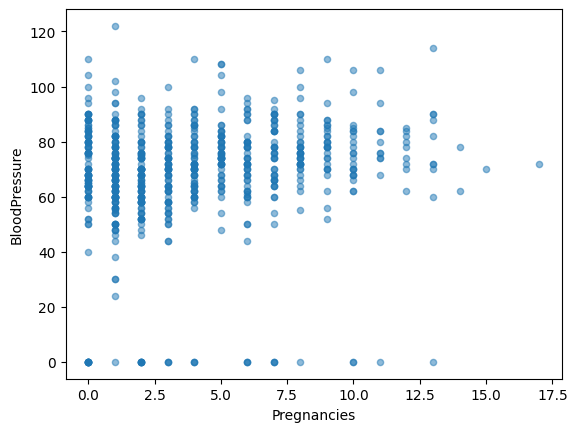

In [176]:
# print(df.loc[:, 'Outcome'].values)
df.sort_values(by='Pregnancies').reset_index(drop=True).plot.scatter(x='Pregnancies', y="BloodPressure", alpha=0.5)

#### Explain the model
1. Data variables\
   1.1. The dependent variable is age, and the independent variable is diabetes.
2. Likelihood function and parameters
5. Prior distribution
6. Formal specification
7. Prior predictive check

## 2. Details of the computation



In [207]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] blood;
     vector[N] age;
     vector[N] glucos;     
}

parameters {
    //prob of success
    real alpha;
    real beta1;
    real beta2;
    real<lower=0> sigma;
}

model {
    //prior
    alpha ~ normal(0, 0.5);
    beta1 ~ normal(0, 1);
    beta2 ~ normal(0, 1);
    
    sigma ~ cauchy(0, 5);
    blood ~ normal(alpha + beta1 * to_vector(age) + beta2 * to_vector(glucos), sigma); //likelihood
}

generated quantities {
    vector[N] blood_rep;

    for (n in 1:N){
     blood_rep [n] = normal_rng(alpha + beta1 * age[n] + beta2 * glucos[n], sigma);
    }
}

"""


### 2-1. Specify data

In [208]:
data = {
"N": len(df), 
"blood": df.loc[:, "BloodPressure"].values,
"age": df.loc[:, "Age"].values,
"glucos": df.loc[:, "Glucose"].values,
}

### 2-2. Build model

In [216]:
stan_model = stan.build(stan_code, data=data)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.9s
Building: 7.1s
Building: 7.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.3s
Building: 7.4s
Building: 7.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file i

Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/xhdqrm7r/model_xhdqrm7r.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.4s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (11.0) than being linked (10.9

### 2-3 Fit the model

- quantify with Hamiltonian Monte Carlo


In [218]:
fit = stan_model.sample(num_chains=4, num_samples=1000) ## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   4% (302/8000)
Sampling:  10% (801/8000)
Sampling:  19% (1501/8000)
Sampling:  44% (3500/8000)
Sampling:  66% (5300/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.002494 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.94 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002279 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002293 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002288 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.88 seconds.
  Adjust your expecta

### 2-4. Validate a fit. Diagnostics

In [220]:
stan_data_simu = az.from_pystan(
    posterior=fit,
    posterior_predictive="blood_rep",
    observed_data=["blood"],
    posterior_model=stan_model,
    coords={"blood": np.arange(data["N"])},
)

In [221]:
stan_data_simu

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='blood / blood_rep'>

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


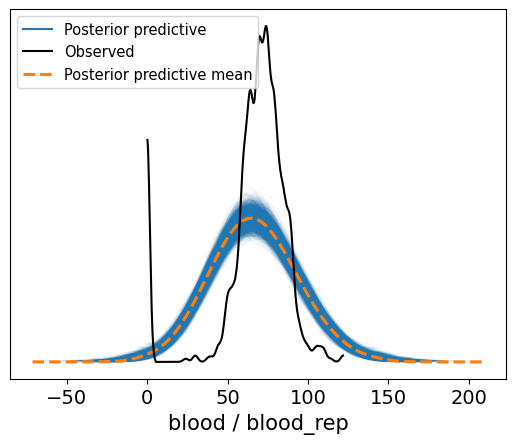

In [223]:
az.plot_ppc(stan_data_simu, data_pairs={"blood": "blood_rep"}, alpha=0.03, textsize=14)

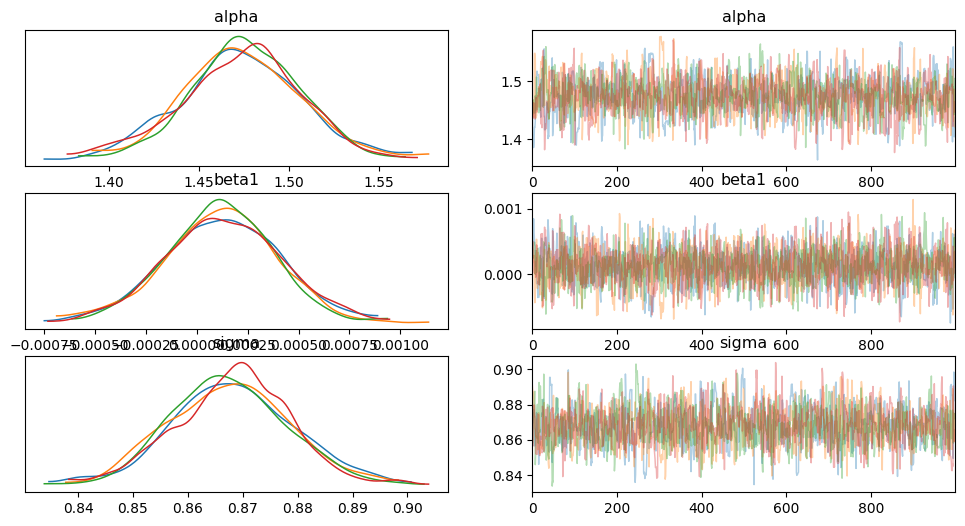

In [148]:
az.plot_trace(stan_data_simu, compact=False);


The visualization shows that the simulated data sets (diabetes_rep) are different from observed log.

In [42]:
def check_treedepth(summary, max_treedepth = 10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # sampler_params = fit.get_sampler_params(inc_warmup=False)
    sampler_params = summary.sample_stats['tree_depth'].values
    depths = [x for y in sampler_params for x in y]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet:
        print(('{} of {} iterations saturated the maximum tree depth of {}'
              + ' ({}%)').format(n, N, max_treedepth, 100 * n / N))
    if n > 0:
        if not quiet:
            print('  Run again with max_treedepth set to a larger value to avoid saturation')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
def check_rhat(summary):
    """Checks the potential scale reduction factors"""
    from math import isnan
    from math import isinf

    fit_summary = fit.summary(probs=[0.5])
    rhats = [x[5] for x in fit_summary['summary']]
    names = fit_summary['summary_rownames']

    no_warning = True
    for rhat, name in zip(rhats, names):
        if (rhat > 1.1 or isnan(rhat) or isinf(rhat)):
            print('Rhat for parameter {} is {}!'.format(name, rhat))
            no_warning = False
    if no_warning:
        print('Rhat looks reasonable for all parameters')
    else:
        print('  Rhat above 1.1 indicates that the chains very likely have not mixed')


In [44]:
def check_div(summary, quiet=False):
    """Check transitions that ended with a divergence"""
    sampler_params = summary.sample_stats['diverging'].values
    divergent = [x for y in sampler_params for x in y]
    # n = sum(divergent)
    divergent = [True if element == "True" else False for element in divergent]
    n = divergent.count(True)
    N = len(divergent)
    print(n)
    if not quiet:
        print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))

    if n > 0:
        if not quiet:
            print('  Try running with larger adapt_delta to remove the divergences')
        else:
            return False
    else:
        if quiet:
            return True

In [57]:
output

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta1,beta2,...,diabetes_rep.759,diabetes_rep.760,diabetes_rep.761,diabetes_rep.762,diabetes_rep.763,diabetes_rep.764,diabetes_rep.765,diabetes_rep.766,diabetes_rep.767,diabetes_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,467.556567,0.601004,0.028667,4.0,27.0,0.0,-464.372932,0.298787,0.000156,0.001149,...,0.222038,0.330533,0.540725,0.946202,0.700127,0.112686,0.247623,0.559029,0.861086,0.337659
1,469.184333,0.971826,0.024153,8.0,255.0,0.0,-468.042719,0.260944,0.000010,0.001621,...,0.233903,0.258801,0.749999,0.568631,0.122460,1.164092,1.191029,0.310811,0.646397,0.650484
2,467.046144,0.985537,0.033627,6.0,63.0,0.0,-466.253243,0.367942,-0.000655,0.001043,...,0.423605,0.760143,0.513990,0.869671,0.187604,0.329917,0.239350,0.803310,0.060476,0.695435
3,469.276788,0.883706,0.026164,7.0,127.0,0.0,-467.543832,0.216601,0.001005,0.001747,...,0.418344,0.106895,-0.195107,0.561070,0.253310,0.767975,0.792083,0.795444,0.250467,0.730134
4,469.981019,0.992394,0.028667,4.0,19.0,0.0,-467.311180,0.295532,0.000357,0.001262,...,0.317547,0.035725,0.319353,0.012227,0.332876,0.450038,0.308963,0.895034,0.487153,0.215903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,469.699470,0.984213,0.026164,6.0,95.0,0.0,-465.979454,0.288922,-0.000277,0.001542,...,-0.092081,0.689713,0.302541,0.949243,0.256230,1.012743,0.288490,0.757798,0.565490,0.560679
3996,469.891004,0.906798,0.028667,6.0,127.0,0.0,-468.323748,0.291729,-0.000020,0.001587,...,0.235631,0.884431,0.299431,0.639454,0.713633,0.488145,0.090295,0.665764,0.212698,0.211697
3997,468.480705,0.966470,0.024153,3.0,11.0,0.0,-468.154523,0.282653,-0.001751,0.001955,...,0.221072,0.746295,0.534375,0.249123,-0.086122,0.454577,0.867886,-0.000269,0.730474,0.416208


In [161]:
output = fit.to_frame()

In [162]:
check_treedepth(stan_data_simu)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [163]:
check_div(stan_data_simu)

0
0 of 4000 iterations ended with a divergence (0.0%)


In [164]:
summary = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [165]:
summary
## mcse_mean : Markov Chain Standard Error statistic
## ess_bulk : effective sample size 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.053,0.489,0.138,1.944,0.009,0.006,3224.0,2561.0,1.0
beta1,0.785,0.063,0.664,0.895,0.001,0.001,2248.0,2134.0,1.0
beta2,0.325,0.018,0.291,0.358,0.000,0.000,2252.0,2183.0,1.0
sigma,21.900,0.541,20.894,22.917,0.009,0.007,3461.0,2519.0,1.0
blood_rep[0],89.030,21.649,47.370,128.186,0.342,0.244,4003.0,3775.0,1.0
...,...,...,...,...,...,...,...,...,...
blood_rep[763],83.861,21.892,41.294,122.289,0.379,0.269,3330.0,3808.0,1.0
blood_rep[764],62.537,21.705,20.359,101.911,0.330,0.236,4320.0,4144.0,1.0
blood_rep[765],63.481,21.874,24.171,106.403,0.337,0.238,4224.0,4096.0,1.0
blood_rep[766],79.003,21.593,39.419,120.300,0.343,0.244,3969.0,3787.0,1.0


In [37]:
summary.loc[summary["ess_bulk"] / 1000 < 0.001]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


<Axes: title={'center': 'alpha'}, xlabel='Quantile', ylabel='ESS for small intervals'>

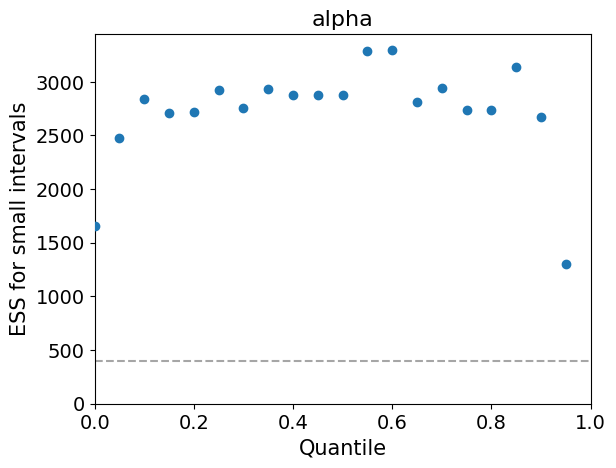

In [38]:
az.plot_ess(fit, var_names=["alpha"])

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (772) in plot_posterior, generating only 40 plots
  warnings.warn(
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/matplotlib/transforms.py:198: RuntimeWarning: coroutine 'build.<locals>.go' was never awaited
  self, lambda _, pop=child._parents.pop, k=id_self: pop(k))


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'diabetes_rep\n0'}>,
        <Axes: title={'center': 'diabetes_rep\n1'}>,
        <Axes: title={'center': 'diabetes_rep\n2'}>,
        <Axes: title={'center': 'diabetes_rep\n3'}>],
       [<Axes: title={'center': 'diabetes_rep\n4'}>,
        <Axes: title={'center': 'diabetes_rep\n5'}>,
        <Axes: title={'center': 'diabetes_rep\n6'}>,
        <Axes: title={'center': 'diabetes_rep\n7'}>],
       [<Axes: title={'center': 'diabetes_rep\n8'}>,
        <Axes: title={'center': 'diabetes_rep\n9'}>,
        <Axes: title={'center': 'diabetes_rep\n10'}>,
        <Axes: title={'center': 'diabetes_rep\n11'}>],
       [<Axes: title={'center': 'diabetes_rep\n12'}>,
        <Axes: title={'center': 'diabetes_rep\n13'}>,
        <Axes: title={'center': 'diabetes_rep\n14'}>,
        <Axes: title={'c

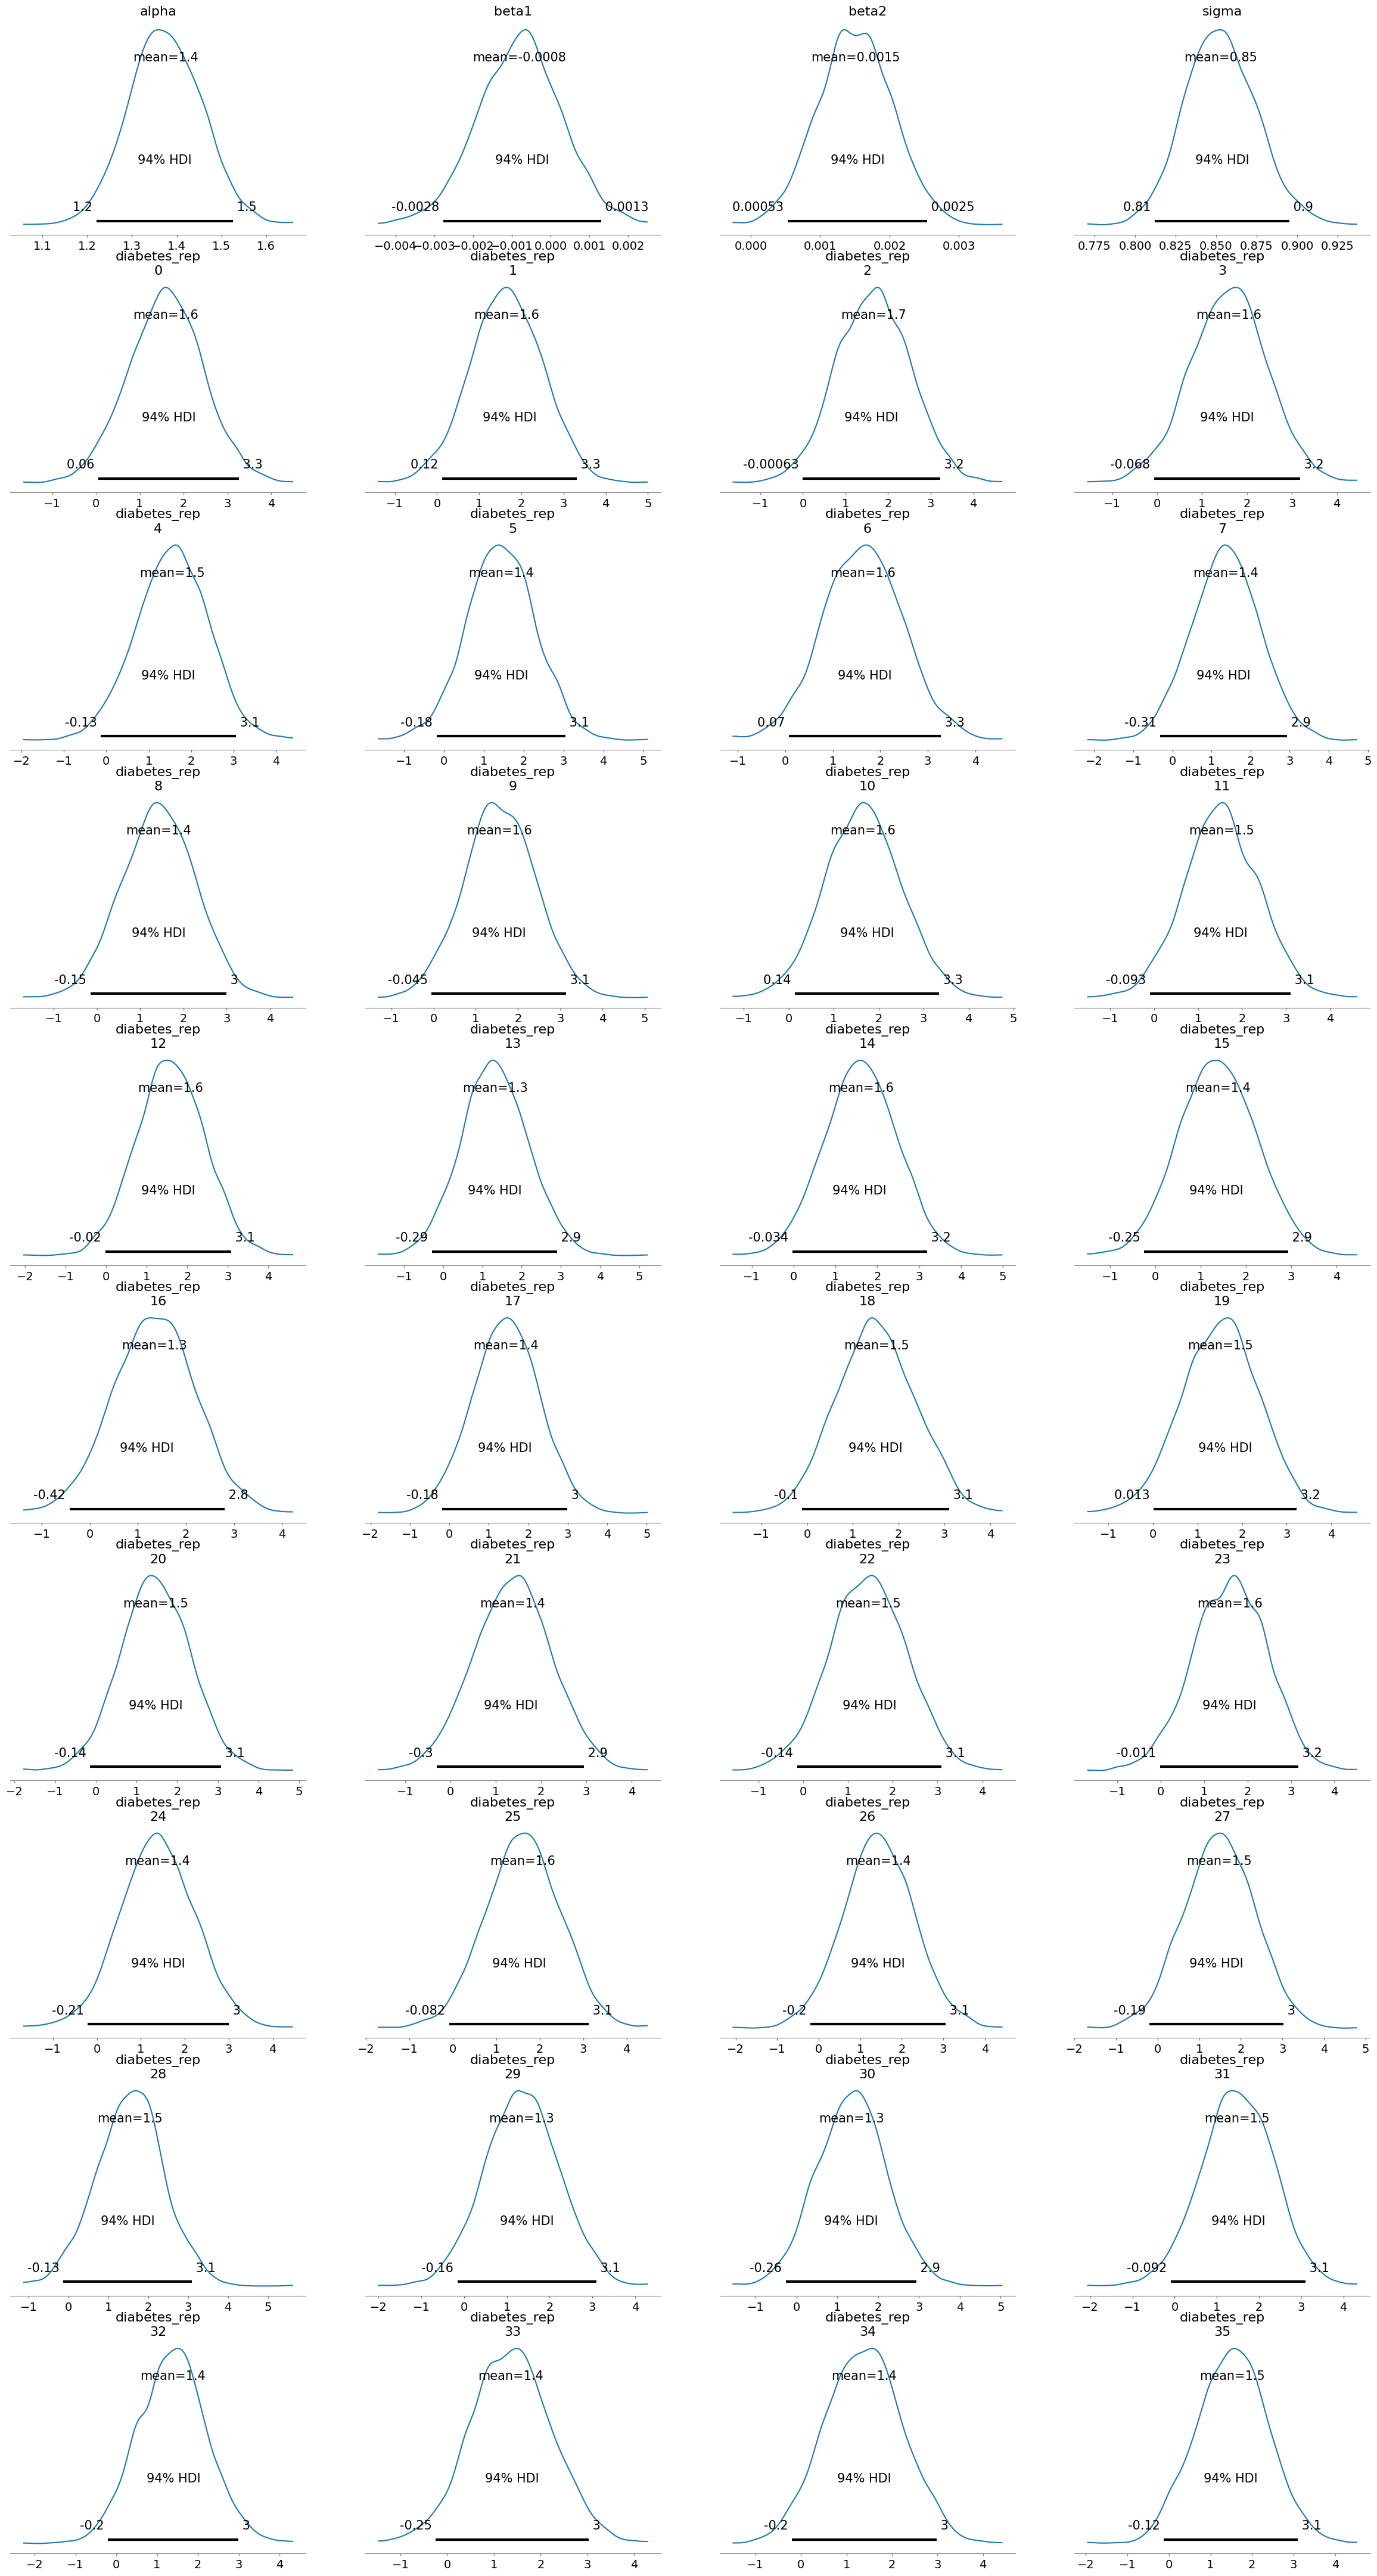

In [39]:
az.plot_posterior(fit)

In [46]:
filtered_df = summary[summary['r_hat'] < 1.0]

In [47]:
filtered_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [48]:
data = {
"N": len(df), 
"diabetes": df.loc[:, "DiabetesPedigreeFunction"].values,
"age": df.loc[:, "Age"].values,
"glucos": df.loc[:, "Glucose"].values,
}

NameError: name 'df' is not defined

In [46]:
stan_model = stan.build(stan_code, data=data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_0uqf64_o/model_k3ychzqb.stan', line 7, column 5: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_0uqf64_o/model_k3ychzqb.stan', line 8, column 5: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [47]:
fit = stan_model.sample(num_chains=4, num_samples=1000) ## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  40% (3200/8000)
Sampling:  54% (4300/8000)
Sampling:  72% (5800/8000)
Sampling:  90% (7200/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000247 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.47 seconds.
  Adjust your e

In [48]:
stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="diabetes_rep",
    observed_data=["diabetes"],
    coords={"diabetes": np.arange(data["N"])},
)

In [71]:
stan_data.posterior_predictive

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000, diabetes_rep_dim_0: 768)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * diabetes_rep_dim_0  (diabetes_rep_dim_0) int64 0 1 2 3 4 ... 764 765 766 767
Data variables:
    diabetes_rep        (chain, draw, diabetes_rep_dim_0) float64 0.4758 ... ...
Attributes:
    created_at:                 2023-11-07T18:58:07.578087
    arviz_version:              0.16.1
    inference_library:          stan
    inference_library_version:  3.7.0

In [50]:
output = fit.to_frame()

In [51]:
output.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta1,beta2,...,diabetes_rep.759,diabetes_rep.760,diabetes_rep.761,diabetes_rep.762,diabetes_rep.763,diabetes_rep.764,diabetes_rep.765,diabetes_rep.766,diabetes_rep.767,diabetes_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,468.412713,0.989601,0.027813,5.0,31.0,0.0,-467.747551,0.235869,0.002158,0.001408,...,0.396884,0.785291,0.125833,0.896521,1.074834,0.647700,0.429713,0.226269,0.080621,0.362998
1,470.218360,0.991041,0.028712,3.0,15.0,0.0,-469.639998,0.278975,0.001080,0.001349,...,-0.198923,0.979826,-0.042196,1.131647,0.813761,0.749925,0.578162,0.535611,1.192872,0.168655
2,469.918627,0.917829,0.027476,6.0,127.0,0.0,-467.057267,0.299755,0.000221,0.001248,...,0.187929,0.260800,0.674541,0.327038,-0.476361,0.365578,0.624370,-0.139019,0.761488,0.210626
3,468.988215,0.972761,0.030483,5.0,31.0,0.0,-466.410694,0.311465,0.001549,0.000968,...,-0.273166,0.724464,0.379800,0.746946,0.582742,0.908187,1.393054,0.224033,0.252805,0.438884
4,466.939475,0.942186,0.027813,6.0,127.0,0.0,-463.648581,0.330885,-0.001944,0.001589,...,0.662647,0.399635,0.017377,0.828652,0.786323,0.675216,0.594046,0.012568,0.784293,0.203609


In [102]:
summary = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [103]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.300,0.053,0.199,0.399,0.001,0.001,1549.0,1367.0,1.0
beta1,-0.000,0.001,-0.002,0.002,0.000,0.000,2875.0,2304.0,1.0
beta2,0.001,0.000,0.001,0.002,0.000,0.000,2207.0,2243.0,1.0
sigma,0.329,0.008,0.313,0.343,0.000,0.000,1545.0,1360.0,1.0
diabetes_rep[0],0.511,0.329,-0.143,1.080,0.005,0.004,3872.0,3599.0,1.0
...,...,...,...,...,...,...,...,...,...
diabetes_rep[763],0.440,0.332,-0.256,0.998,0.005,0.004,3942.0,3585.0,1.0
diabetes_rep[764],0.475,0.332,-0.121,1.112,0.005,0.004,3680.0,4034.0,1.0
diabetes_rep[765],0.473,0.328,-0.102,1.137,0.005,0.004,4107.0,3744.0,1.0
diabetes_rep[766],0.468,0.326,-0.150,1.076,0.006,0.004,3522.0,4011.0,1.0


In [189]:
az.plot_posterior(stan_data)

NameError: name 'stan_data' is not defined

<!-- comment - paper : how to read visualization -->

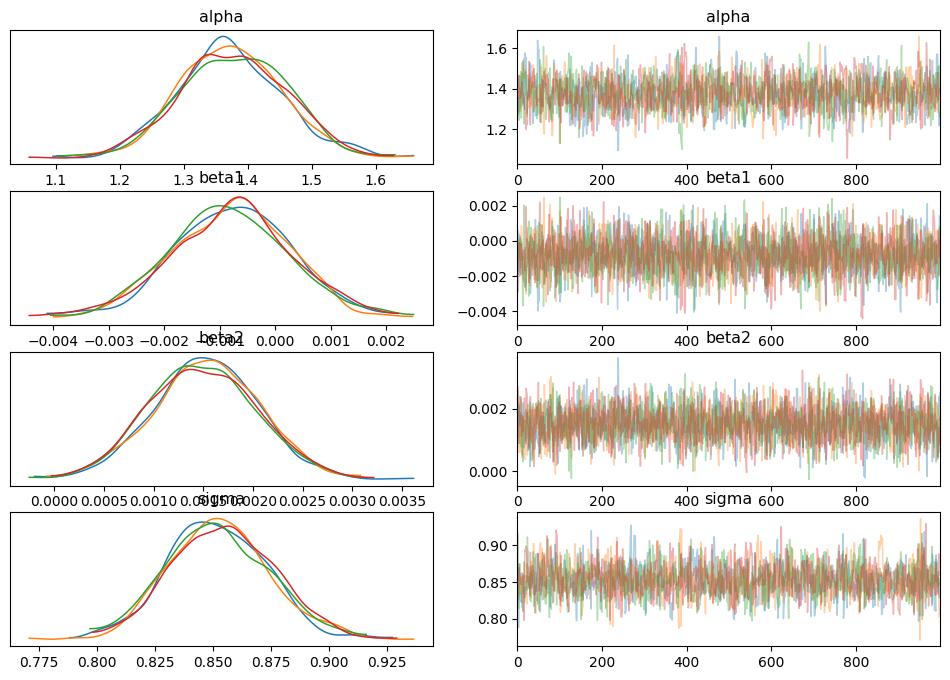

In [49]:
az.plot_trace(stan_data_simu, compact=False);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

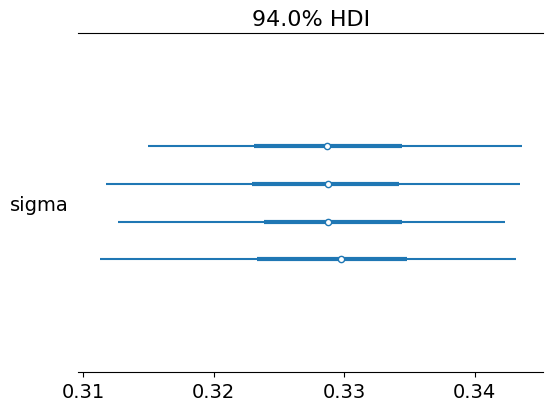

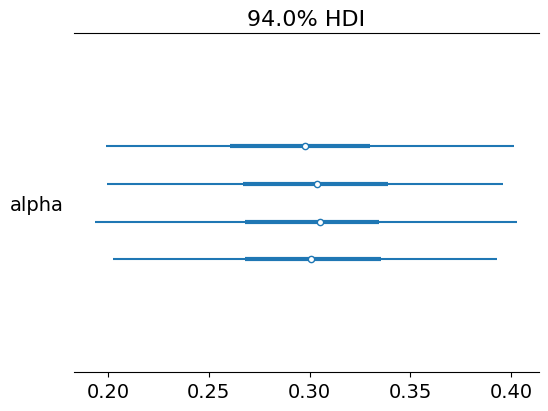

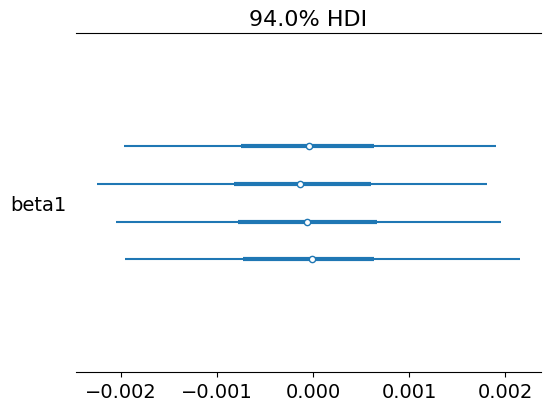

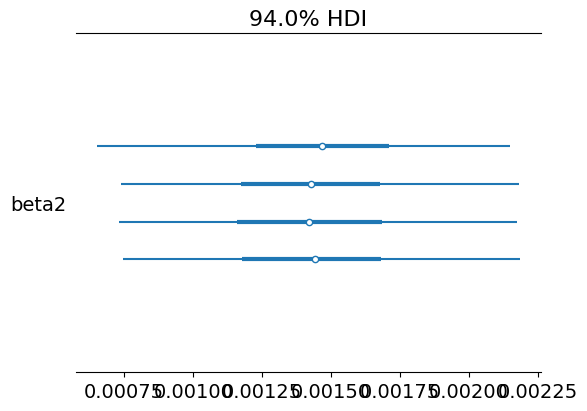

In [108]:
size = (10, 50)

az.plot_forest(stan_data.posterior.sigma)
az.plot_forest(stan_data.posterior.alpha)
az.plot_forest(stan_data.posterior.beta1)
az.plot_forest(stan_data.posterior.beta2)


In [60]:
print("alpha has a mean of ", output["alpha"].mean(), "and std of ", output["alpha"].std())

alpha has a mean of  0.30034020023624364 and std of  0.05324942612102796


In [61]:
print("beta has a mean of ", output["beta1"].mean(), "and std of ", output["beta1"].std())

beta has a mean of  -6.807844385695504e-05 and std of  0.001065744314015121


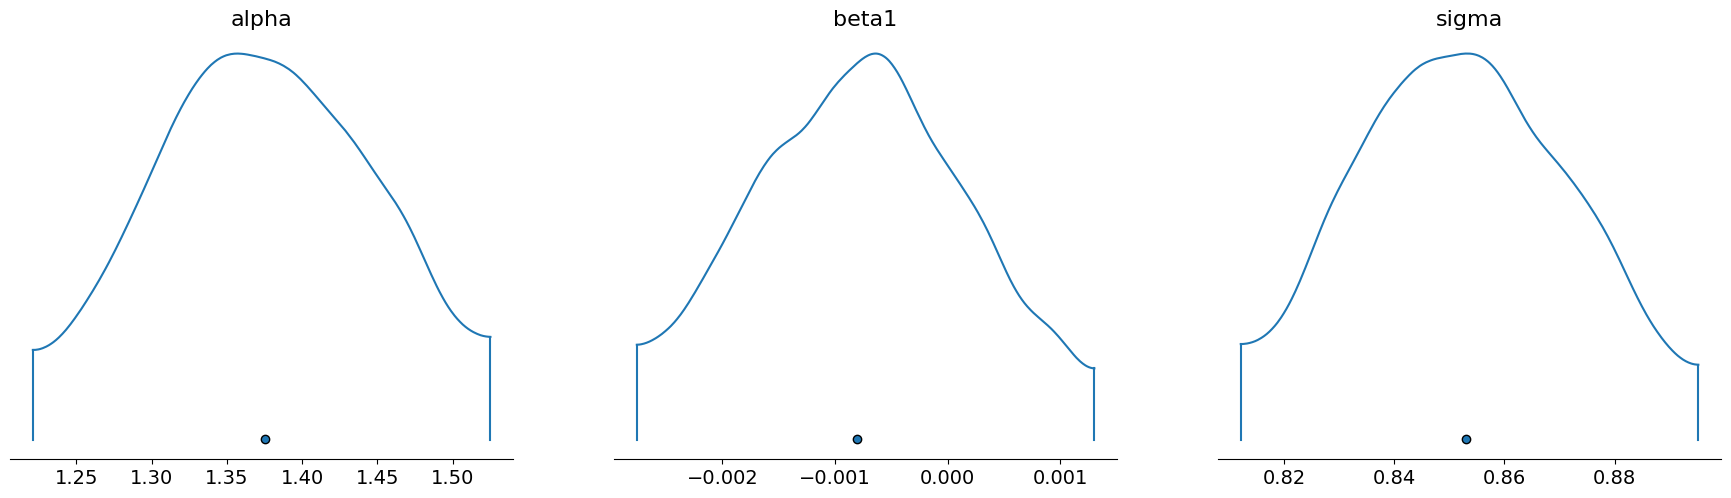

In [50]:
az.plot_density(fit, var_names=["alpha", "beta1", "sigma"]);


({'BF10': 0.5112097948643544, 'BF01': 1.9561440528840852},
 <Axes: title={'center': 'The BF_10 is 0.51\nThe BF_01 is 1.96'}, xlabel='a', ylabel='Density'>)

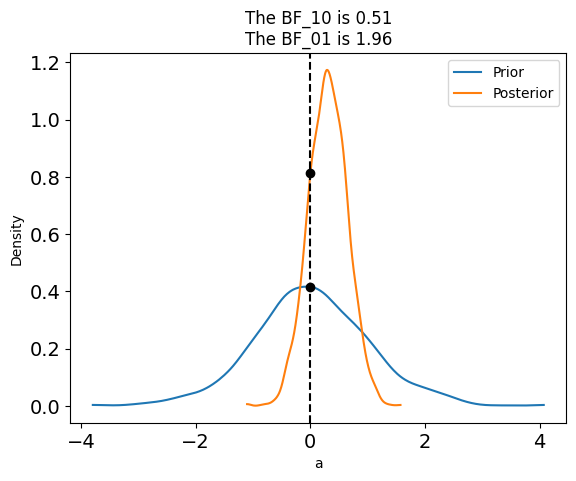

In [112]:
alpha = stan_data_simu.posterior.alpha
beta1=  stan_data_simu.posterior.beta1
beta2=  stan_data_simu.posterior.beta2

x1 = np.random.normal(0, 1, 1000)
x2 = np.random.normal(0, 1, 1000)

posterior_density = np.random.normal(alpha + beta1 * x1 + beta2 * x2, stan_data.posterior.sigma)

idata = az.from_dict(
    posterior={"a": posterior_density}, prior={"a": np.random.normal(0, 1, 1000)}
)

az.plot_bf(idata, var_name="a", ref_val=0)

## 3. ploting

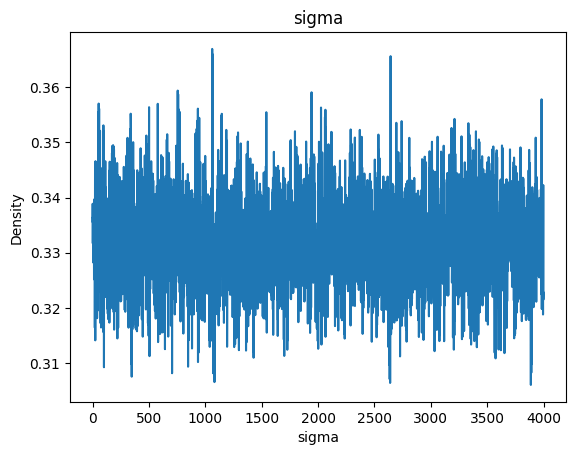

In [31]:
sigma = output["sigma"]  # array with shape (8, 4000)
sigma.plot()
plt.title('sigma')
plt.xlabel('sigma')
plt.ylabel('Density')
plt.show()

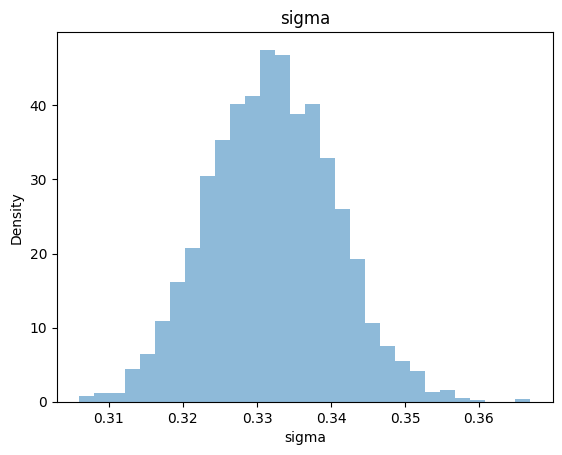

In [32]:
sigma = output["sigma"]  # array with shape (8, 4000)
sigma.plot.hist(bins=30, density=True, alpha=0.5)
plt.title('sigma')
plt.xlabel('sigma')
plt.ylabel('Density')
plt.show()

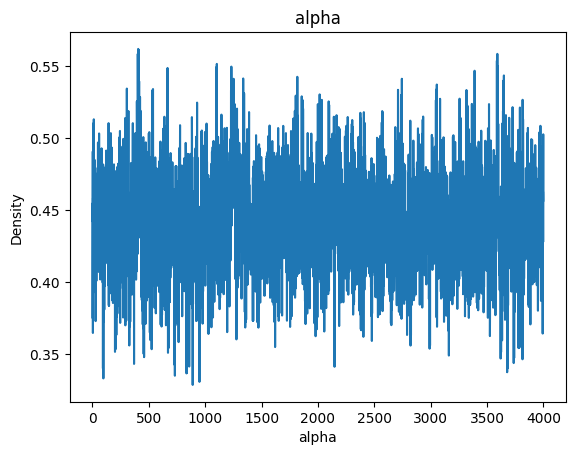

In [36]:
mu = output["alpha"]  # array with shape (8, 4000)
mu.plot()
plt.title('alpha')
plt.xlabel('alpha')
plt.ylabel('Density')
plt.show()

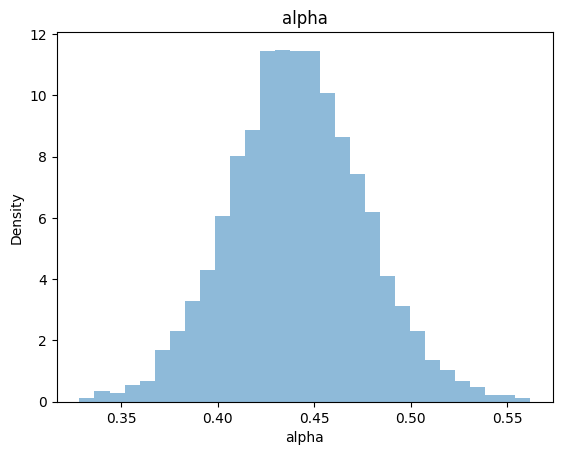

In [35]:
mu = output["alpha"]  # array with shape (8, 4000)
mu.plot.hist(bins=30, density=True, alpha=0.5)
plt.title('alpha')
plt.xlabel('alpha')
plt.ylabel('Density')
plt.show()

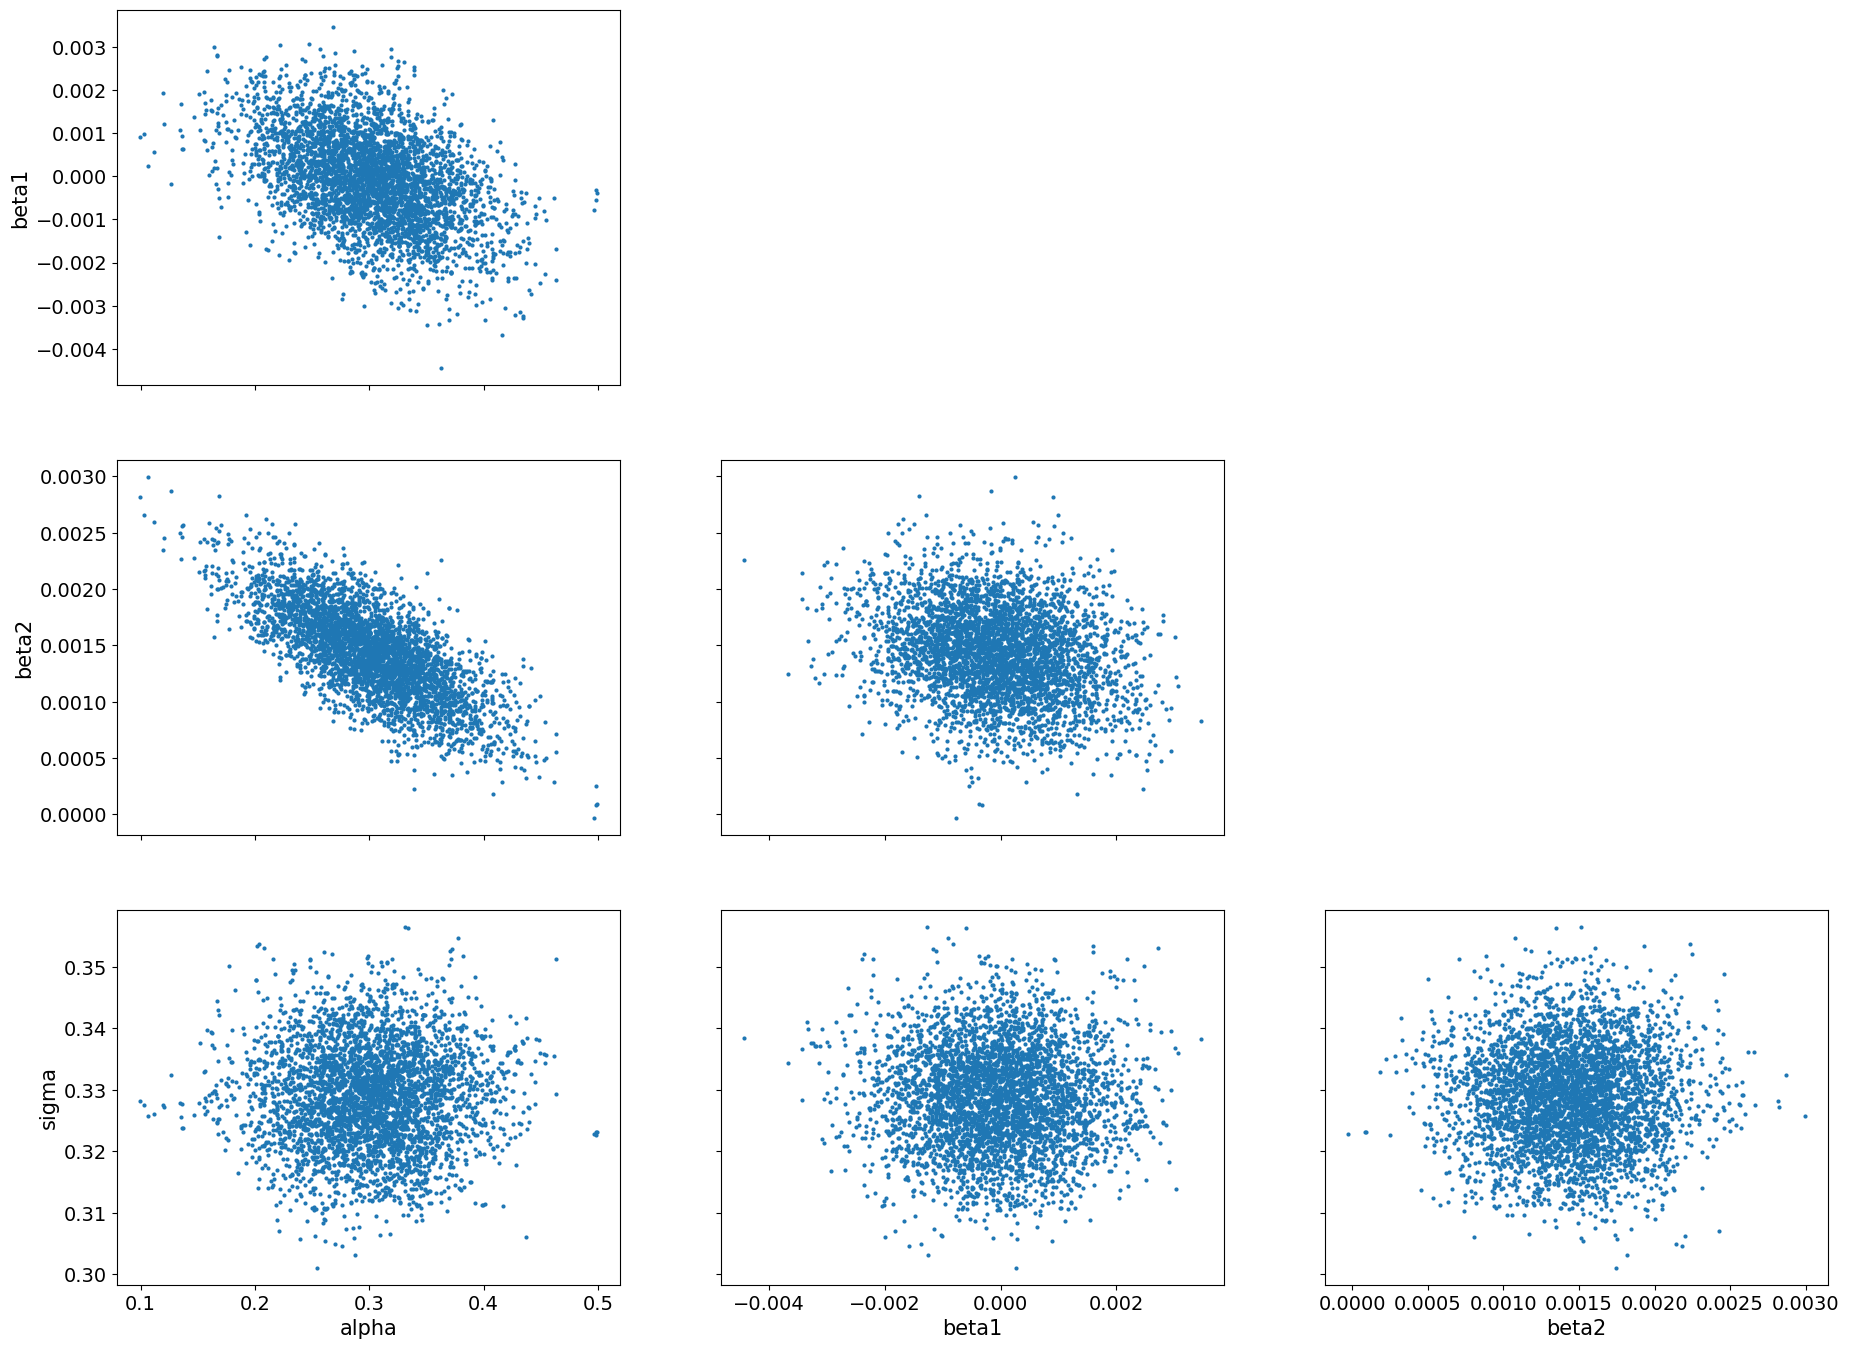

In [113]:
az.plot_pair(
    stan_data_simu,
    divergences=True,
);

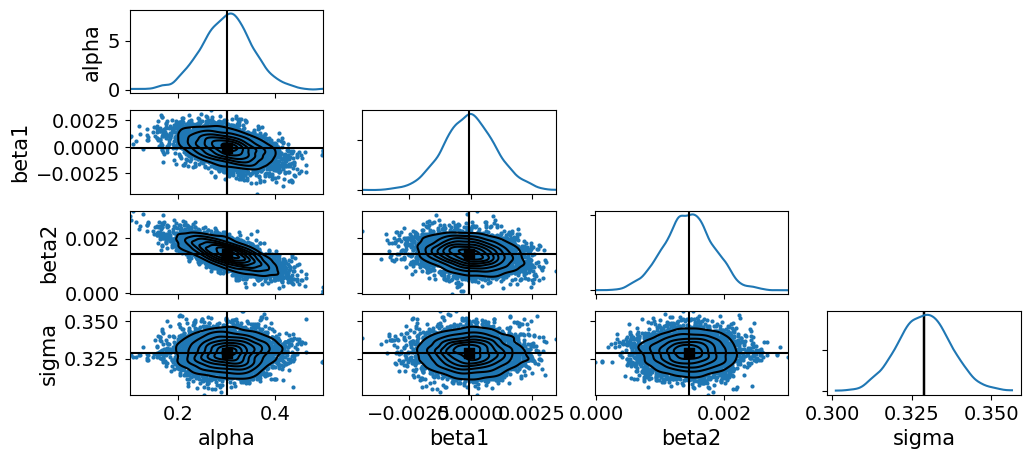

In [114]:
az.plot_pair(
    stan_data_simu,
    divergences=True,
    var_names=["alpha", "beta1", "beta2", "sigma"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    # coords=coords,
    point_estimate="median",
    figsize=(11.5, 5),
);

## 0. delete cache of model

In [210]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [211]:
httpstan.cache.list_model_names()

['models/vvinljrr', 'models/74lr2nfw', 'models/xhdqrm7r', 'models/fgpwnysh']

In [215]:
httpstan.cache.delete_model_directory('models/vvinljrr') ## add the model pointer you want to remove

## 0. Saving model

In [24]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [25]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')


In [188]:
import pickle

In [26]:
# with open("model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# fit_new = data_dict['fit']
# # fit = data_list[1]

In [ ]:
# with open("model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : stan_model, 'fit' : fit}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)